<a href="https://colab.research.google.com/github/mohammadathania/ALY6110/blob/main/Individual_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession 
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
df = spark.read.csv("BostonHousing.csv", inferSchema=True, header = True)
df.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
only_features = ['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b','lstat']

In [6]:
assembler = VectorAssembler(inputCols=only_features, outputCol= 'features')

In [7]:
feat_df = assembler.transform(df).select('features')
feat_df.show(10)

+--------------------+
|            features|
+--------------------+
|[0.00632,18.0,2.3...|
|[0.02731,0.0,7.07...|
|[0.02729,0.0,7.07...|
|[0.03237,0.0,2.18...|
|[0.06905,0.0,2.18...|
|[0.02985,0.0,2.18...|
|[0.08829,12.5,7.8...|
|[0.14455,12.5,7.8...|
|[0.21124,12.5,7.8...|
|[0.17004,12.5,7.8...|
+--------------------+
only showing top 10 rows



In [8]:
#standadize the data 

scaler = StandardScaler(
    inputCol = 'features',
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True,
).fit(feat_df)

#when we transform the dataset feature will still remain in it
df_scaled = scaler.transform(feat_df)
df_scaled.show(10)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|
|[0.08829,12.5,7.8...|[-0.4098372459997...|
|[0.14455,12.5,7.8...|[-0.4032965606564...|
|[0.21124,12.5,7.8...|[-0.3955433024705...|
|[0.17004,12.5,7.8...|[-0.4003331395864...|
+--------------------+--------------------+
only showing top 10 rows



In [9]:
#fit PCA model
n_components = 2
pca = PCA(
    k= n_components,
    inputCol = 'scaledFeatures',
    outputCol = 'pcaFeatures'
).fit(df_scaled)

df_pca = pca.transform(df_scaled)
print("explained variance ratio", pca.explainedVariance.toArray())
df_pca.show(10)

explained variance ratio [0.47129606 0.11025193]
+--------------------+--------------------+--------------------+
|            features|      scaledFeatures|         pcaFeatures|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|[2.21266184319277...|
|[0.08829,12.5,7.8...|[-0.4098372459997...|[1.35753765586535...|
|[0.14455,12.5,7.8...|[-0.4032965606564...|[0.84121214171331...|
|[0.21124,12.5,7.8...|[-0.3955433024705...|[0.17975039564828...|
|[0.17004,12.5,7.8...|[-0.4003331395864...|[1.07312213803569...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [11]:
#collect data in Numpy Array
x_pca = df_pca.rdd.map(lambda row: row.pcaFeatures).collect()
x_pca = np.array(x_pca)
x_pca

array([[2.09622303, 0.77234843],
       [1.45581099, 0.59139995],
       [2.07254655, 0.59904658],
       ...,
       [0.31205166, 1.15410433],
       [0.27025162, 1.04033206],
       [0.12567884, 0.76122473]])

In [12]:
#convert array to dataframe 
df_pca = pd.DataFrame(x_pca, columns= ['PC1','PC2'])
df_pca.head()

,PC1,PC2
0,2.096223,0.772348
1,1.455811,0.591400
2,2.072547,0.599047
3,2.608922,-0.006864
4,2.455755,0.097615


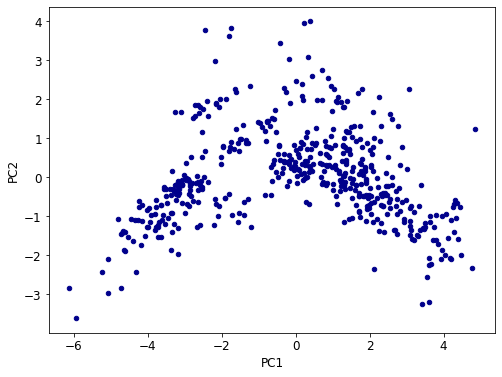

In [13]:
#plot two principal components 
plt.rcParams['figure.figsize'] = 8,6
plt.rcParams['font.size']= 12
ax1 = df_pca.plot.scatter(x='PC1', y='PC2', c='DarkBlue')

In [14]:

#linear regression using Pyspark
output = assembler.transform(df)

#input vs output 
finalized_data = output.select("features","medv")

finalized_data.show()

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
|[0.02985,0.0,2.18...|28.7|
|[0.08829,12.5,7.8...|22.9|
|[0.14455,12.5,7.8...|27.1|
|[0.21124,12.5,7.8...|16.5|
|[0.17004,12.5,7.8...|18.9|
|[0.22489,12.5,7.8...|15.0|
|[0.11747,12.5,7.8...|18.9|
|[0.09378,12.5,7.8...|21.7|
|[0.62976,0.0,8.14...|20.4|
|[0.63796,0.0,8.14...|18.2|
|[0.62739,0.0,8.14...|19.9|
|[1.05393,0.0,8.14...|23.1|
|[0.7842,0.0,8.14,...|17.5|
|[0.80271,0.0,8.14...|20.2|
|[0.7258,0.0,8.14,...|18.2|
+--------------------+----+
only showing top 20 rows



In [15]:
#split the train and test data
train_data,test_data = finalized_data.randomSplit([0.8,0.2])

In [16]:
#train model
regressor = LinearRegression(featuresCol= 'features', labelCol= 'medv')

regressor = regressor.fit(train_data)

In [17]:
#print model cooeff and intercept
coeff = regressor.coefficients

intr = regressor.intercept

print("The coeeficient of the model is : %a" %coeff)
print("The intercept of the model is : %a" %intr)

The coeeficient of the model is : DenseVector([-0.108, 0.0578, 0.0286, 2.5819, -21.9667, 3.3875, 0.0097, -1.7283, 0.361, -0.0133, -1.0018, 0.0092, -0.5885])
The intercept of the model is : 43.269540833942514


In [18]:
#evaluate the model
pred = regressor.evaluate(test_data)
#predict the model
pred.predictions.show()

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[0.01096,55.0,2.2...|22.0|27.343110834772652|
|[0.0187,85.0,4.15...|23.1|25.184253820088422|
|[0.02177,82.5,2.0...|42.3| 37.25412772616434|
|[0.02729,0.0,7.07...|34.7| 30.42948998456543|
|[0.02763,75.0,2.9...|30.8|32.000935277105285|
|[0.02899,40.0,1.2...|26.6|21.132615938580265|
|[0.03041,0.0,5.19...|18.5| 18.95331118976862|
|[0.03049,55.0,3.7...|31.2|28.422307660349766|
|[0.03306,0.0,5.19...|20.6| 21.89852332770168|
|[0.03445,82.5,2.0...|24.1| 30.01052076002267|
|[0.03502,80.0,4.9...|28.5|34.318065446601366|
|[0.03548,80.0,3.6...|20.9|21.477904812621155|
|[0.03659,25.0,4.8...|24.8| 26.19138212467391|
|[0.04011,80.0,1.5...|33.3|   36.421948075988|
|[0.04294,28.0,15....|20.6|27.834224202303485|
|[0.04337,21.0,5.6...|20.5| 24.00352244688625|
|[0.0578,0.0,2.46,...|37.2|33.305169248290895|
|[0.06263,0.0,11.9...|22.4|23.348497316734058|
|[0.06417,0.0

In [19]:
#calaculate the model stats
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = "medv", predictionCol="prediction", metricName = "rmse")

In [20]:
# root mean square
rmse = eval.evaluate(pred.predictions)
print("Rmse",rmse)

# mean square error
mse = eval.evaluate(pred.predictions, {eval.metricName : "mse"})
print("mse",mse)

#Mean absolute error
mae = eval.evaluate(pred.predictions, {eval.metricName : "mae"})
print("mae",mae)

#r2
r2 = eval.evaluate(pred.predictions, {eval.metricName : "r2"})
print("R2",r2)

Rmse 4.297229298883422
mse 18.466179647182106
mae 3.338769637044976
R2 0.7147901352884587
